In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import cv2

from sklearn.model_selection import train_test_split

from torch import nn, cuda
from torch.utils import data

from sklearn import metrics
#from transformers import ViTFeatureExtractor, ViTModel, AdamW
from tqdm.auto import tqdm

#import splitfolders
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L


import random

In [2]:
pip install tensorflow_addons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys

path_to_utils='/content/drive/My Drive/COVID-19_Radiography_Dataset'
sys.path.append(path_to_utils)

In [5]:
os.chdir(path_to_utils)

print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1S3v3yKoL4cZ3EG1HSCCgDh8sk5ppw1Sg/COVID-19_Radiography_Dataset


In [6]:
labels={0:'viral pneumonia',1:'normal',2:'viral pneumonia',3:'covid'}

In [28]:
def loadFiles(path): #path is list of paths, labels is a dictionary 
  #function for loading images as np_arrays to train/val/test sets
  trainImages = []
  y_train=[]

  for p, lab in zip(path,[0,1,2,3]):
    for r, d, f in os.walk(p):
      for file in f:
        filepath = os.path.join(r, file)
        img = cv2.imread(filepath)

        # Resizing image to size (28, 28)
        img = cv2.resize(img, (220, 220), interpolation=cv2.INTER_CUBIC) #consider adjusting image size

        trainImages.append(img)
        y_train.append(lab)
    
    print(len(trainImages))

  trainImagesNumpy = np.array(np.array(trainImages))
  y_train=np.array(y_train)
  
  return trainImagesNumpy, y_train

In [29]:
#used only covid images as subsample of data for testing code
path_train=['./train (1)/class1','./train (1)/class2', './train (1)/class3', './train (1)/class4']
x_train, y_train = loadFiles(path_train)
x_train.shape

907
7832
11990
14435


(14435, 220, 220, 3)

In [30]:
path_val=['./val (1)/class1','./val (1)/class2', './val (1)/class3', './val (1)/class4']

x_valid, y_valid = loadFiles(path_val)
x_valid.shape

303
2617
4004
4820


(4820, 220, 220, 3)

In [31]:
path_test=['./test (1)/class1','./test (1)/class2', './test (1)/class3', './test (1)/class4']
x_test, y_test = loadFiles(path_test)
x_test.shape

135
1164
1781
2144


(2144, 220, 220, 3)

In [32]:
BUFFER_SIZE = 1024
BATCH_SIZE = 4
INPUT_SHAPE = (110, 110, 3)
AUTO = tf.data.AUTOTUNE

#(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_valid)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 14435
Validation samples: 4820
Testing samples: 2144


In [22]:
IMAGE_SIZE = 120 
PATCH_SIZE = 10
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [33]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(IMAGE_SIZE+20, IMAGE_SIZE+20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [34]:
#This layer takes images as input and divides them into patches.class Patches(L.Layer):
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [35]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

Index selected: 3.


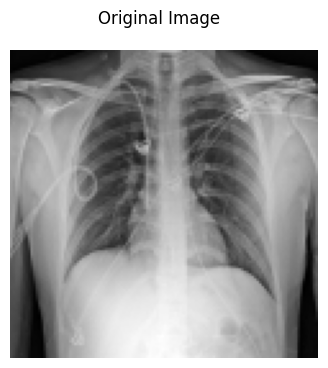

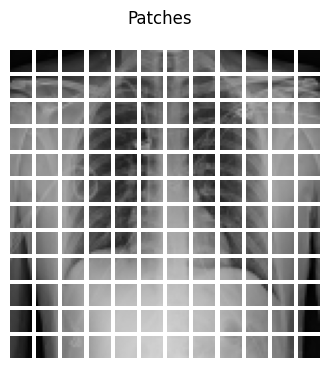

In [36]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images) #patches = patch_layer(images=image_batch)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches) #random_index = patch_layer.show_patched_image(images=image_batch, patches=patches) 

In [37]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2 
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
] 
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [38]:
EPOCHS = 100
DOWNSTREAM_EPOCHS = 100

In [39]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        ) 
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            ) 
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            #adjusted
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [40]:
def dense_projection(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [41]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [42]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)
        x = L.Add()([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = L.Flatten()(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [43]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        #adjusted 
        (   unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [44]:
class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            ( 
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [45]:
test_images = next(iter(valid_ds))


train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)


mae_model.compile(
    optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)


Epoch 1/3
3609/3609 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.1287
Idx chosen: 2


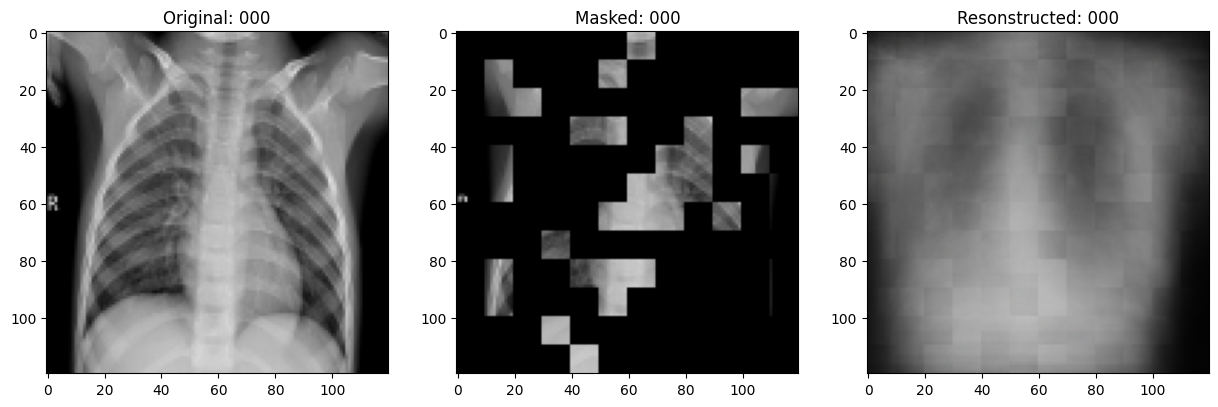

3609/3609 [==============================] - 210s 50ms/step - loss: 0.0288 - mae: 0.1287 - val_loss: 0.0269 - val_mae: 0.1269 - lr: 0.0010
Epoch 2/3
3609/3609 [==============================] - 173s 48ms/step - loss: 0.0197 - mae: 0.1050 - val_loss: 0.0233 - val_mae: 0.1131 - lr: 0.0010
Epoch 3/3
1205/1205 [==============================] - 16s 14ms/step - loss: 0.0183 - mae: 0.0985
Loss: 0.02
MAE: 0.10


In [46]:
#run training with validation loss and mae reported
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), es, rlp],
)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")


In [71]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True

encoder = mae_model.encoder

downstream_model = keras.Sequential(
    [
        L.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        L.BatchNormalization(),
        L.GlobalAveragePooling1D(),
        L.Dense(4, activation="softmax"),
    ],
    name="downstream_model",
)

patch_layer.trainable = False
patch_encoder.trainable = False
encoder.trainable = False

In [72]:
y_tr=y_train[:,np. newaxis]
y_tst=y_test[:,np. newaxis]
y_val=y_valid[:,np. newaxis]


In [73]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


In [74]:
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
Y_Train = encoder.fit_transform(y_tr.reshape(-1,1))
Y_Val = encoder.fit_transform(y_val.reshape(-1,1))

In [75]:
Y_Test = encoder.fit_transform(y_tst.reshape(-1,1))

In [76]:
train_ds=prepare_data(x_train,Y_Train)
valid_ds=prepare_data(x_valid,Y_Val, is_train=False)
test_ds=prepare_data(x_test,Y_Test, is_train=False)


In [77]:
f1=tfa.metrics.F1Score(average='macro',num_classes=4)

In [78]:
auc=tf.keras.metrics.AUC(multi_label = True, num_labels=4)
cat_acc=tf.keras.metrics.CategoricalAccuracy()

In [79]:
downstream_model.compile(
    optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",f1,auc,cat_acc]
)

es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1)



downstream_model.fit(train_ds, validation_data=valid_ds, epochs=DOWNSTREAM_EPOCHS, callbacks=[es, rlp]) #EPOCHS_DOWNSTREAM

loss, accuracy, f1,auc, cat_acc = downstream_model.evaluate(valid_ds)
accuracy = accuracy * 100
print(f"avg AUC on the validation set: {auc}%.")

Epoch 1/3
3609/3609 [==============================] - 64s 16ms/step - loss: 0.3540 - accuracy: 0.8662 - f1_score: 0.8218 - auc_4: 0.9709 - categorical_accuracy: 0.8662 - val_loss: 3.3127 - val_accuracy: 0.1936 - val_f1_score: 0.1151 - val_auc_4: 0.6768 - val_categorical_accuracy: 0.1936 - lr: 0.0010
Epoch 2/3
3609/3609 [==============================] - 55s 15ms/step - loss: 0.3792 - accuracy: 0.8639 - f1_score: 0.8135 - auc_4: 0.9615 - categorical_accuracy: 0.8639 - val_loss: 3.4999 - val_accuracy: 0.2340 - val_f1_score: 0.1652 - val_auc_4: 0.6911 - val_categorical_accuracy: 0.2340 - lr: 0.0010
Epoch 3/3
1205/1205 [==============================] - 13s 11ms/step - loss: 3.5503 - accuracy: 0.1844 - f1_score: 0.1129 - auc_4: 0.6965 - categorical_accuracy: 0.1844
avg AUC on the validation set: 0.6965225338935852%.


In [80]:
loss, accuracy, f1, AUC1, cat_acc = downstream_model.evaluate(test_ds)
accuracy = accuracy * 100
print(loss, accuracy, f1, AUC1, cat_acc)

536/536 [==============================] - 6s 11ms/step - loss: 3.5313 - accuracy: 0.1912 - f1_score: 0.1159 - auc_4: 0.7029 - categorical_accuracy: 0.1912
3.5312678813934326 19.12313401699066 0.11589693278074265 0.7029467225074768 0.19123134016990662


In [82]:
x=downstream_model.predict(test_ds)

536/536 [==============================] - 5s 9ms/step


In [90]:
y_test.shape

(2144,)

In [91]:

y_pred=np.argmax(x, axis=1)

In [92]:
import sklearn

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [94]:
# Make list of diagnoses and set average weighting
diagnoses = ['Viral Pneumonia','Normal', 'Lung Opacity','COVID' ]
avg_setting = 'macro'
num_decimals = 5

# Create function to calculate multiclass AUC
def multiclass_metrics(test, pred, average="macro"):
    
    # Create set of unique classes
    unique = set(test)
    auc_dict = {}
    acc_dict = {}
    
    # Loop through each class
    for class_i in unique:
        
        # Create list of classes other than class_i
        other_class = [x for x in unique if x != class_i]

        # Get test / prediction values for each class
        new_test = [0 if x in other_class else 1 for x in test]
        new_pred = [0 if x in other_class else 1 for x in pred]
        
        #print(accuracy_score(new_test, new_pred))
        accuracy = accuracy_score(new_test, new_pred)
        acc_dict[class_i] = accuracy

        # Calculate AUC, add to dictionary
        auc = roc_auc_score(new_test, new_pred, average = average)
        auc_dict[class_i] = auc
        
    return acc_dict, auc_dict

# Calculate evaluations metrics
precision = precision_score(y_test, y_pred, average=avg_setting)
recall = recall_score(y_test, y_pred, average=avg_setting)
f1 = f1_score(y_test, y_pred, average=avg_setting)
multi_acc, multi_auc = multiclass_metrics(y_test, y_pred)

# Print results
print('Multiclass AUC scores:')
i = 0
for key, value in multi_auc.items():
    print(f'    {diagnoses[i]}: {round(value, num_decimals)}')
    i += 1
print('\nMulticlass Accuracy scores:')
i = 0
for key, value in multi_acc.items():
    print(f'    {diagnoses[i]}: {round(value, num_decimals)}')
    i += 1
print(f'\nPrecision: {round(precision, num_decimals)}')
print(f'Recall:    {round(recall, num_decimals)}')
print(f'F1 score:  {round(f1, num_decimals)}')

Multiclass AUC scores:
    Viral Pneumonia: 0.50691
    Normal: 0.5
    Lung Opacity: 0.52809
    COVID: 0.51889

Multiclass Accuracy scores:
    Viral Pneumonia: 0.93703
    Normal: 0.52006
    Lung Opacity: 0.71922
    COVID: 0.20616

Precision: 0.31686
Recall:    0.27109
F1 score:  0.1159


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
